In [1]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [27]:
import os
import datetime
import io
import pickle
import re
import json
import gzip
import cProfile
import lxml.etree
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
# import ray
import scipy.stats
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon, box
import geopandas as geopd
import pandas as pd
import querier as qr
from dotenv import load_dotenv
load_dotenv()

import ses_ling.data.socioeconomic as ses_data
import ses_ling.data.access as data_access
import ses_ling.utils.paths as path_utils
import ses_ling.utils.stats as stats_utils
import ses_ling.utils.geometry as geo_utils
import ses_ling.utils.spatial_agg as spatial_agg
import ses_ling.utils.text_process as text_process
import ses_ling.visualization.utils as viz_utils
import ses_ling.visualization.ses as ses_viz
from ses_ling.language import Region, Language

representativeness of sample we have for ses, 

corr populaton size from twitter / census

factors driving locallly/globally

diversity of mistakes per group / psecificity of some for some ses groups. doc2vec similarities between ses classes

In [3]:
paths = path_utils.ProjectPaths()
all_cntr_shapes = geopd.read_file(paths.countries_shapefile)

In [4]:
with open(paths.ext_data / 'countries.json') as f:
    countries_dict = json.load(f)
cc = 'GB'
cc_dict = countries_dict[cc]
year_from = 2015
year_to = 2021
res_attr_kwargs = dict(
    nighttime_acty_th=0.5,
    all_acty_th=0.1,
    count_th=3,
    gps_dups_th=500,
    pois_dups_th=500,
)

In [5]:
_cc_init_params = {
    cc: {'cell_size': 'MSOA_BGC', 'ses_idx': "IMD", "res_cell_size": "MSOA_BGC"}
}
lang = Language(
    'en', 'English', _cc_init_params, countries_dict,
    all_cntr_shapes=all_cntr_shapes,
    year_from=year_from, year_to=year_to,
    latlon_proj=cc_dict['xy_proj'], # TOCHANGE when several countries
    user_nr_words_th=100,
    cells_nr_users_th=15,
    res_attr_kwargs=res_attr_kwargs,
)
reg = lang.regions[0]

shape_geodf loaded for GB
ses_df loaded for GB
cell_levels_corr loaded for GB
lt_rules loaded for GB
regions done
done


In [9]:
lang.user_mask.sum()

Keeping 149908 users out of 358334


149908

In [ ]:
lang.reload_countries_dict()

# Quick stats and checks at user level

In [7]:
lang.user_corpora.head()

,nr_tweets,nr_words,nr_unique_words
user_id,,,
00030426231cf2773a81f9897ecbeb951cd2ee7bf2d0118694cf5292edee1720902aed6e5a30783b25d75b7171b376cb81750aef025074226c6d0211a6fb6a9f,64,2507,731
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,124,1683,715
000faaaa6e11d566321800c3187781f6651521366dc43312f992b2a145a9e86447232fbb1e3c4f0e76e5ddc3f3f9000715ce6ae3f3c5e2a221c676faa28a85ec,37,445,258
001b4e7bcb4f4980e67d738ef38fe5b63f759e8cdb9938c4ac06354bb37d5f1dfe0e31e522a026e6ba70c2e4a5806b6d4cba9292d472cc6d792c68d9bf72a43c,100,1001,453
001e74edd2ca43f22a6a936eb5315f06bc62a3fcaa1ebd40a06fe05edc6f6687081134f00ba779a51c05e8379cd51c8e802d7bbd53cbaf3b864f9a16a50dc5ae,43,400,233


In [9]:
user_mistakes = lang.user_mistakes
user_mistakes.head()

count  \
user_id                                            cat_id     rule_id                               
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                    2   
                                                   GRAMMAR    DEPEND_ON                         1   
                                                              ORDER_OF_WORDS_WITH_NOT           1   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE      1   
                                                              WHITESPACE_RULE                  37   

                                                                                           default  \
user_id                                            cat_id     rule_id                                
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                   NaN   
                                                   GRAMMAR    DEPEND_ON                        NaN   
                                                              ORDER_OF_WORDS_WITH_NOT          NaN   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE     NaN   
                                                              WHITESPACE_RULE                  NaN   

                                                                                           distance_tokens  \
user_id                                            cat_id     rule_id                                        
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                           NaN   
                                                   GRAMMAR    DEPEND_ON                                NaN   
                                                              ORDER_OF_WORDS_WITH_NOT                  NaN   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE             NaN   
                                                              WHITESPACE_RULE                          NaN   

                                                                                           is_rule_group  \
user_id                                            cat_id     rule_id                                      
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                        True   
                                                   GRAMMAR    DEPEND_ON                             True   
                                                              ORDER_OF_WORDS_WITH_NOT              False   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE           NaN   
                                                              WHITESPACE_RULE                        NaN   

                                                                                           min_prev_matches  \
user_id                                            cat_id     rule_id                                         
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZATION                            NaN   
                                                   GRAMMAR    DEPEND_ON                                 NaN   
                                                              ORDER_OF_WORDS_WITH_NOT                   NaN   
                                                   TYPOGRAPHY COMMA_PARENTHESIS_WHITESPACE              NaN   
                                                              WHITESPACE_RULE                           NaN   

                                                                                                                                         name  \
user_id                                            cat_id     rule_id                                                                           
000003962867f2d312d942838cdb2535b950589f2e85f31... CASING     CAPITALIZAT

In [10]:
lang.user_df['nr_words'].describe()

count    3.583340e+05
mean     3.475908e+03
std      1.460625e+04
min      4.000000e+00
25%      3.060000e+02
50%      8.020000e+02
75%      2.201000e+03
max      2.125035e+06
Name: nr_words, dtype: float64

In [ ]:
lang.user_nr_words_th = 100

In [11]:
user_mistakes_cat = lang.user_mistakes.groupby(['user_id', 'cat_id']).sum()

In [76]:
# Most common mistakes
# full_user_mistakes_cat = user_mistakes_cat.unstack(level=1).stack(dropna=False).fillna(0)
# full_user_mistakes_cat.groupby('cat_id').mean().sort_values(by='cat_freq_per_word', ascending=False)
(user_mistakes_cat.groupby('cat_id').sum() / user_mistakes_cat.index.levels[0].size).sort_values(by='freq_per_word', ascending=False)

,cat_freq_per_word,cat_freq_per_tweet
cat_id,,
TYPOGRAPHY,0.023225,0.306905
CASING,0.007341,0.090328
PUNCTUATION,0.006666,0.088851
TYPOS,0.00384,0.048111
GRAMMAR,0.003474,0.044675
MISC,0.001605,0.021474
STYLE,0.001238,0.015237
CONFUSED_WORDS,0.000618,0.007746
REDUNDANCY,0.000207,0.002938


In [ ]:
raw_global_rule_freqs = lang.user_mistakes.groupby(['cat_id', 'rule_id'])['count'].sum()

most common categories

In [ ]:
raw_global_rule_freqs.groupby('cat_id').sum().sort_values(ascending=False)

cat_id
TYPOGRAPHY             21847667
PUNCTUATION             8365090
CASING                  6319657
TYPOS                   4712720
GRAMMAR                 3986177
MISC                    1904725
STYLE                   1593411
CONFUSED_WORDS           672064
REDUNDANCY               251715
COMPOUNDING              208212
COLLOCATIONS             114180
SEMANTICS                 15375
NONSTANDARD_PHRASES       12620
REPETITIONS_STYLE          4183
Name: count, dtype: int64

In [894]:
cat_top_rules = raw_global_rule_freqs.reset_index().sort_values(by=['cat_id', 'count']).groupby('cat_id').tail(10).set_index(['cat_id', 'rule_id']).loc['COLLOCATIONS']
cat_top_rules, lang.lt_rules['name'].loc[cat_top_rules.index].values

(                          count
 rule_id                        
 MENTION_ABOUT              1390
 GO_TO_HOME                 1747
 IN_FACEBOOK                2191
 ARRIVE_ON_AT_THE_BEACH     2605
 WORRY_FOR                  4315
 ATD_VERBS_TO_COLLOCATION   5058
 LOT_OF                     6585
 A_MY                      16333
 FED_UP_OF_WITH            18583
 NON_ANTI_JJ               22948,
 array(['Collocation: consider (about)',
        'Collocation: go to home (go home)', 'in (on) Facebook',
        'Collocation: arrive on/at the beach',
        "Wrong collocation: 'worry for' (worry about)",
        'Collocation: Word + to + PRP|NNP|DT', 'Collocation: lot (of)',
        'article + possessive form', 'Collocation: fed up of/with',
        "missing hyphen in adjectives with 'non/anti'"], dtype=object))

# Same at cell level

In [114]:
lang.cells_nr_users_th = 15

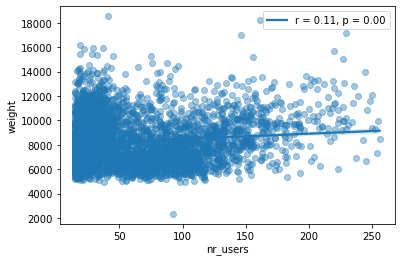

In [35]:
ax = sns.regplot(x=pop_twitter, y=pop_real, scatter_kws={'alpha': .4}, line_kws={'label': 'r = {:.2f}, p = {:.2f}'.format(*pearson_res)})
ax.legend()

### Viz single cat/rule

In [ ]:
lang.map_mistake('WHITESPACE_RULE', normed_bboxes=False, total_width=100)

In [66]:
cat_avg_freq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)
m = lang.cells_geodf.join(cat_avg_freq, how='inner').explore('GRAMMAR')

In [71]:
m.save(lang.paths.case_figs / 'mistake_cat_freqs.html')

# SES / inter-rules/cats correlations

correlation betwen rules freqs to recover categories, see if they match LT's

also simple quesrion like: are tweets hsorter in poorer areas? pb: twitter change in 2017 of tweets' max length. should be ok if enough users per cell, but atm it's clearly not enough with the 10-20

investigate influence of neihbouring cells, communities on speech. is a poor area surrounded by rich ones going t be speaking "more standard"? correlation Gi (not star!) with cell's own z-score

## Set up subreg, SES idc and cell size

In [6]:
lang.add_ses_idx('all')

In [397]:
lang.change_cell_sizes(GB='MSOA_BGC')

In [7]:
focus_cities = [
    'London', 'Manchester', 'Birmingham', 'Liverpool', 'Leeds', 'Sheffield', 
    'Newcastle upon Tyne', 'Bristol, City of'
]
subregions_dict = {c: 'rgn20nm' if c == 'London' else 'lad20nm' for c in focus_cities}
subreg_df = pd.DataFrame.from_dict({'GB': subregions_dict}, orient='index').stack().rename_axis(index=['cc', 'subreg']).rename('agg_col').to_frame().set_index('agg_col', append=True)

metro_areas = pd.read_csv(lang.paths.ext_data / lang.regions[0].cell_levels_corr_files['metro_area'])
subreg_df = subreg_df.join(metro_areas.set_index('metro_area')['LAD20CD'], on='subreg')

In [996]:
cells_mask = lang.make_subregions_mask(subreg_df, set_cells_mask=False)

285 cells in Birmingham.
55 cells in Bristol, City of.
168 cells in Leeds.
139 cells in Liverpool.
983 cells in London.
306 cells in Manchester.
145 cells in Newcastle upon Tyne.
103 cells in Sheffield.


In [71]:
pop_d = {}
for city, city_d in lang.iter_subregs(subreg_df, ses_metric='total_pop'):
    pop_d[city] = {}
    pop_d[city]['nr_users'] = city_d['user_res_cell'].groupby('cell_id').size().sum()
    pop_d[city]['total_pop'] = city_d['cells_ses_metric'].sum()
pop_df = pd.DataFrame.from_dict(pop_d, orient='index').rename_axis('city')

285 cells in Birmingham.
55 cells in Bristol, City of.
168 cells in Leeds.
139 cells in Liverpool.
983 cells in London.
306 cells in Manchester.
145 cells in Newcastle upon Tyne.
103 cells in Sheffield.


In [77]:
from adjustText import adjust_text

Text(0, 0.5, 'Number of residents found on Twitter')

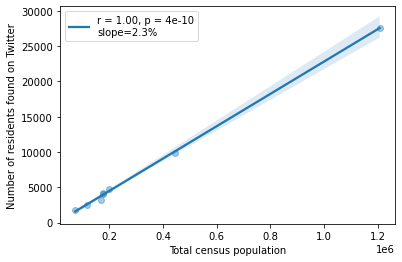

In [100]:
fig, ax = plt.subplots()
x = [d['total_pop'] for k, d in pop_d.items()]
y = [d['nr_users'] for k, d in pop_d.items()]
# annots = [ax.text(d['total_pop'], d['nr_users'], k) for k, d in pop_d.items()]
reg_res = scipy.stats.linregress(x, y)
ax = sns.regplot(
    x=x,
    y=y,
    scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}\nslope={reg_res.slope:.1%}'},
    ax=ax,
)
# adj_text_kw = {'arrowprops': {'arrowstyle': '-', 'color': 'gray', 'lw': 0.1}}
# adjust_text(annots, x=x, y=y, ax=ax, **adj_text_kw)
ax.legend()
ax.set_xlabel("Total census population")
ax.set_ylabel('Number of residents found on Twitter')

Text(0, 0.5, 'Number of residents found on Twitter')

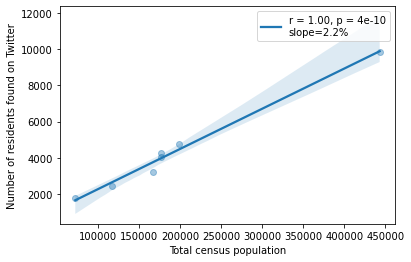

In [101]:
fig, ax = plt.subplots()
x = [d['total_pop'] for k, d in pop_d.items() if k != 'London']
y = [d['nr_users'] for k, d in pop_d.items() if k != 'London']
reg_res = scipy.stats.linregress(x, y)
ax = sns.regplot(
    x=x,
    y=y,
    scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}\nslope={reg_res.slope:.1%}'},
    ax=ax,
)
ax.legend()
ax.set_xlabel("Total census population")
ax.set_ylabel('Number of residents found on Twitter')

In [674]:
# isin_region = lang.make_subregions_mask(subreg_df, set_cells_mask=True)
del lang.cells_mask
# lang.cells_mask = (
#     lang.cells_mask
#     & isin_region
# )

## By cat

In [608]:
wavg_ses = lang.cells_ses_df.loc[lang.relevant_cells, 'wavg'].unstack()
uavg_cat_freq = lang.cells_mistakes.loc[lang.relevant_cells].groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)
corrs = wavg_ses.join(uavg_cat_freq, how='inner',).corr()

In [609]:
corrs.loc[wavg_ses.columns, uavg_cat_freq.columns]

cat_id,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
metric,,,,,,,,,,,,,,
asscore,-0.065196,0.057414,0.022421,0.315408,0.376925,0.138495,0.006032,0.155979,-0.038046,-0.015270,-0.041347,0.244181,-0.259962,0.341687
bhsscore,-0.008567,-0.010355,-0.017047,-0.109741,-0.141501,-0.062793,0.018525,-0.003917,0.023881,0.046326,0.047838,0.025638,0.227739,-0.074917
criscore,-0.016017,0.021640,0.005215,0.146766,0.198801,0.060336,0.007479,0.069928,-0.054315,0.003780,0.018461,0.158052,0.014387,0.211245
cypscore,-0.064062,0.057450,0.019056,0.233063,0.262078,0.095730,0.019849,0.144971,-0.020216,-0.018552,-0.022121,0.179876,-0.161010,0.250919
density_pop,0.083321,-0.021867,-0.042397,-0.019571,-0.006841,-0.011380,0.016243,0.009618,-0.024508,0.030240,0.041212,0.105672,0.168196,0.059381
eduscore,-0.073116,0.055008,0.018327,0.273802,0.320446,0.119784,0.015193,0.147136,-0.031602,-0.017650,-0.027003,0.200587,-0.191715,0.299918
empscore,-0.066419,0.029494,0.021648,0.235912,0.288869,0.141120,0.010988,0.079325,-0.032025,-0.014141,-0.005187,0.124767,-0.077742,0.272209
envscore,-0.012447,0.002142,0.012659,-0.049709,-0.114361,0.004351,0.047306,-0.048276,0.033059,0.039439,0.026068,-0.071793,0.281034,-0.049041
gbscore,-0.041321,0.009957,0.008068,-0.055431,-0.094522,-0.010684,-0.006141,-0.016489,0.040712,-0.014314,-0.036456,-0.098906,-0.096247,-0.131702


In [613]:
max_corr_by_ses_idx = corrs.loc[wavg_ses.columns, uavg_cat_freq.columns].abs().idxmax(axis=1)
p_list = []
for ses_id, cat_id in max_corr_by_ses_idx.items():
    ses_mask = wavg_ses[ses_id].notnull()
    r, p = scipy.stats.pearsonr(wavg_ses.loc[ses_mask, ses_id], uavg_cat_freq.loc[ses_mask, cat_id])
    p_list.append(p)
max_corr_by_ses_idx = (
    max_corr_by_ses_idx.rename(uavg_cat_freq.columns.name)
     .to_frame()
     .assign(
        r=corrs.stack().loc[
            zip(max_corr_by_ses_idx.index, max_corr_by_ses_idx.values)
        ].values,
        p=p_list,
))
max_corr_by_ses_idx

,cat_id,r,p
metric,,,
asscore,GRAMMAR,0.376925,4.973266e-154
bhsscore,TYPOGRAPHY,0.227739,8.996180e-55
criscore,TYPOS,0.211245,3.333699e-47
cypscore,GRAMMAR,0.262078,1.452695e-72
density_pop,TYPOGRAPHY,0.168196,2.738347e-32
eduscore,GRAMMAR,0.320446,1.708662e-109
empscore,GRAMMAR,0.288869,1.968021e-88
envscore,TYPOGRAPHY,0.281034,1.318933e-83
gbscore,TYPOS,-0.131702,4.110320e-19


In [610]:
max_corr_by_cat = corrs.loc[wavg_ses.columns, uavg_cat_freq.columns].abs().idxmax(axis=0)
p_list = []
for cat_id, ses_id in max_corr_by_cat.items():
    ses_mask = wavg_ses[ses_id].notnull()
    r, p = scipy.stats.pearsonr(wavg_ses.loc[ses_mask, ses_id], uavg_cat_freq.loc[ses_mask, cat_id])
    p_list.append(p)
    
max_corr_by_cat = max_corr_by_cat.rename(wavg_ses.columns.name).to_frame().assign(
    r=corrs.stack().loc[zip(max_corr_by_cat.index, max_corr_by_cat.values)].values,
    p=p_list
)
max_corr_by_cat

,metric,r,p
cat_id,,,
CASING,net_income18,0.107034,6.582932e-14
COLLOCATIONS,cypscore,0.057450,1.030355e-04
COMPOUNDING,total_pop,0.058369,4.513521e-05
CONFUSED_WORDS,asscore,0.315408,5.879753e-106
GRAMMAR,asscore,0.376925,4.973266e-154
MISC,empscore,0.141120,9.795593e-22
NONSTANDARD_PHRASES,envscore,0.047306,1.389672e-03
PUNCTUATION,asscore,0.155979,2.993286e-26
REDUNDANCY,criscore,-0.054315,2.415307e-04


### Corr viz

why many points in low values? because deprivation is actually ~ extreme poverty, like see income for instance, it's based on unemployment rates and stuff, cf p.29 of technical report

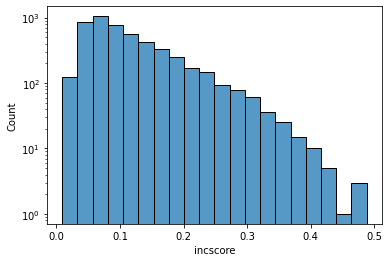

In [831]:
ax = sns.histplot(x=wavg_ses['incscore'], bins=20, log_scale=False)#, y=wavg_ses.loc[mask.loc[mask].index, 'incscore'])
ax.set_yscale('log')

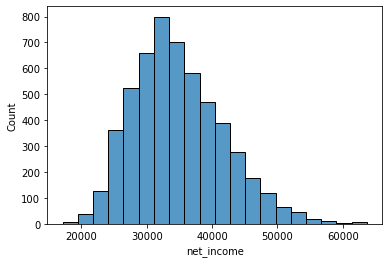

In [855]:
ax = sns.histplot(x=wavg_ses['net_income'], bins=20, log_scale=False)#, y=wavg_ses.loc[mask.loc[mask].index, 'incscore'])
# ax.set_yscale('log')
# ax.set_xscale('log')

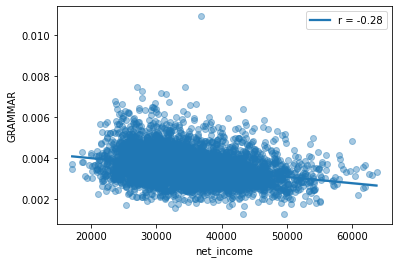

In [833]:
fig, ax = plt.subplots()
x = wavg_ses['net_income']
y = uavg_cat_freq['GRAMMAR']
r = y.to_frame().corrwith(x).values[0]
ax = sns.regplot(x=x, y=y, scatter_kws={'alpha': .4}, line_kws={'label': f'r = {r:.2f}'})
ax.legend()
# ax.set_title(key)

983 cells in London.
57 cells in Manchester.
132 cells in Birmingham.
61 cells in Liverpool.
107 cells in Leeds.
70 cells in Sheffield.
55 cells in Bristol, City of.


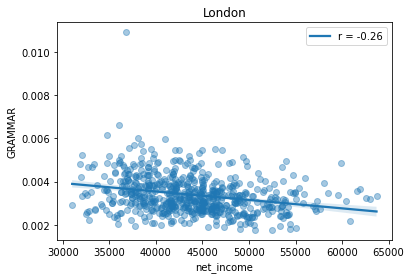

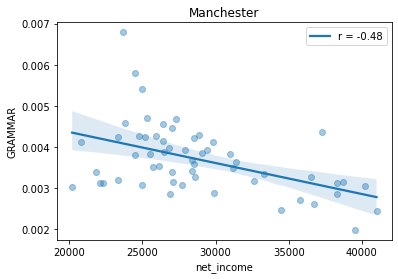

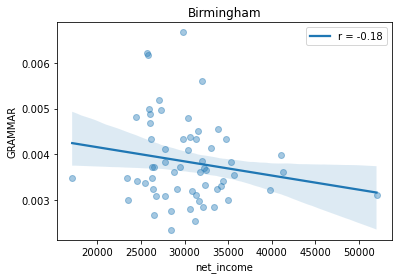

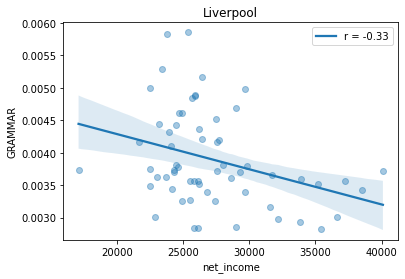

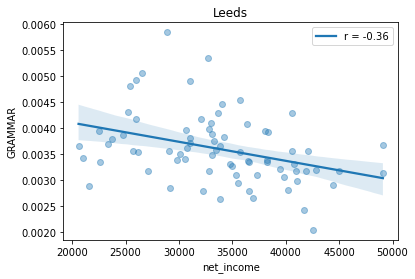

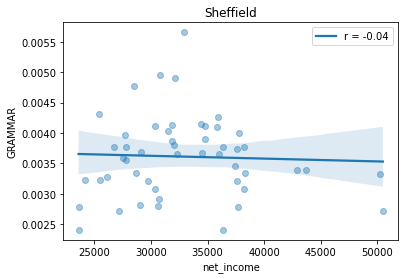

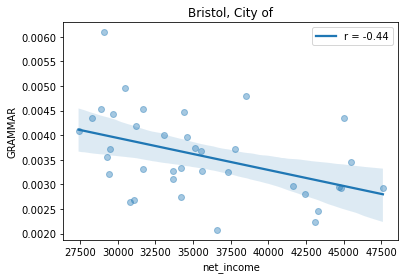

In [679]:
for city, city_df in subreg_df.groupby('subreg'):
    reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    fig, ax = plt.subplots()
    x = wavg_ses.loc[reg_mask.loc[reg_mask].index, 'net_income']
    y = uavg_cat_freq.loc[reg_mask.loc[reg_mask].index, 'GRAMMAR']
    r = y.to_frame().corrwith(x).values[0]
    ax = sns.regplot(x=x, y=y, scatter_kws={'alpha': .4}, line_kws={'label': f'r = {r:.2f}'})
    ax.legend()
    ax.set_title(city)

<AxesSubplot:xlabel='net_income', ylabel='GRAMMAR'>

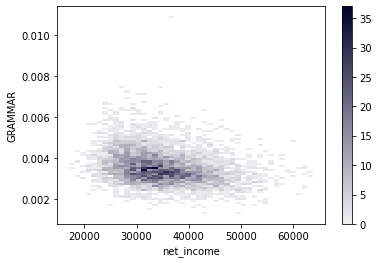

In [424]:
sns.histplot(
    x=wavg_ses.loc[lang.relevant_cells, 'net_income'],
    y=uavg_cat_freq.loc[lang.relevant_cells, 'GRAMMAR'],
    # binrange=((0, 5e-4), None),
    cmap="light:#03012d",
    cbar=True,
)

/home/thomaslouf/.conda/envs/ses-ling/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='TYPOS', ylabel='imdscore'>

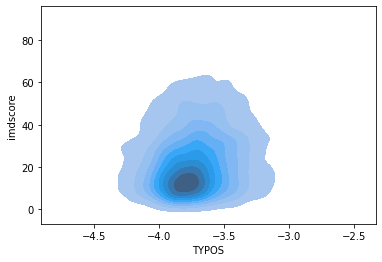

In [58]:
sns.kdeplot(
    x=np.log10(uavg_cat_freq.loc[lang.relevant_cells, 'TYPOS']),
    y=wavg_ses.loc[lang.relevant_cells, 'imdscore'],
    fill=True,
)

next, when actual good correlation, sns.regplot / lmplot

### Maps

In [ ]:
lang.map_mistake(cat_id='GRAMMAR', clip_to_cells=True)

In [ ]:
m = lang.explore_mistake(cat_id='GRAMMAR')

In [95]:
lang.res_attr_kwargs = {'nighttime_acty_th': 0.5,
 'all_acty_th': 0.1,
 'count_th': 3,
 'gps_dups_th': 100,
 'pois_dups_th': 500}

In [94]:
lang.reload_countries_dict()

In [ ]:
cat_id = 'GRAMMAR' # ['TYPOS', 'CONFUSED_WORDS', 'COMPOUNDING'] #'
ses_id = 'net_income18'
# ses_values = lang.select_ses_metric(ses_id)
# mistake_values = lang.select_mistakes(cat_id=cat_id)
# common_idx = ses_values.index[ses_values.notnull()].intersection(
#     mistake_values.index[mistake_values.notnull()]
# )
# ses_values = ses_values.loc[common_idx]
# mistake_values = mistake_values.loc[common_idx]
# # tooltip_df = lang.cells_ses_df['wavg'].unstack().applymap(lambda f: '{:.2g}'.format(f))

for city, city_d in lang.iter_subregs(subreg_df, ses_metric=ses_id, cat_id=cat_id):
    # reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    # cells_idc = reg_mask.loc[reg_mask].index
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    ses_values = city_d['cells_ses_metric']
    mistake_values = city_d['cells_mistake']
    mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
    ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
    ol_mask = ses_ol_mask & mistake_ol_mask

    
    r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=ses_values.loc[ol_mask],
        y=mistake_values.loc[ol_mask],
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)
    save_path = lang.figs_path / f'corr_{ses_id}_vs_{cat_id}_in_{city}.pdf'
    fig.savefig(save_path, bbox_inches='tight')
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.clear()

    save_path = lang.figs_path / f'{mistake_values.name}_of_{cat_id}_in_{city}.html'
    z_plot = mistake_values.loc[mistake_ol_mask]
    cbar_label = f'User average of word frequency of {z_plot.name}'
    m = lang.map_interactive(
        z_plot,# tooltip_df=tooltip_df.loc[cells_idc],
        save_path=save_path
    )
    fig, axes = lang.map_continuous_choro(
        z_plot, cmap='plasma', cbar_label=cbar_label,
        save_path=save_path.with_suffix('.pdf'), show=True
    )
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.clear()

    save_path = lang.figs_path / f'{ses_id}_in_{city}.html'
    z_plot = ses_values.loc[ses_ol_mask]
    cbar_label = f'{z_plot.name} of {ses_id}'
    m = lang.map_interactive(
        z_plot, cmap='viridis_r',
        # tooltip_df=tooltip_df.loc[cells_idc],
        save_path=save_path
    )
    fig, axes = lang.map_continuous_choro(
        z_plot, cmap='plasma_r', cbar_label=cbar_label,
        save_path=save_path.with_suffix('.pdf'), show=False
    )
    fig.savefig(save_path.with_suffix('.png'), bbox_inches='tight')
    fig.clear()

In [801]:
lang.change_cell_sizes(GB='lda')

In [ ]:
reg.cell_levels_corr.loc[reg.cell_levels_corr['RGN20NM'] == 'London'].groupby('LAD20NM').first()

## Aggregating all categories:

In [ ]:
wavg_ses = lang.cells_ses_df.loc[lang.relevant_cells, 'wavg'].unstack()
uavg_all_cats_freq = lang.cells_mistakes.groupby(['cell_id'])['uavg_freq_per_word'].sum().fillna(0)
# corrs = wavg_ses.join(uavg_all_cats_freq, how='inner',).corr()

Keeping 5391 cells out of 7201, 1810 discarded from `cells_nr_users_th`


In [ ]:
wavg_ses.corrwith(uavg_all_cats_freq,)# method='spearman')

metric
asscore                  -0.244038
bhsscore                  0.090039
criscore                  0.182220
cypscore                  0.037745
eduscore                 -0.132148
empscore                  0.040673
envscore                  0.451044
gbscore                  -0.322476
hddscore                  0.093167
idcscore                  0.120459
idoscore                  0.215451
imdscore                  0.147576
incscore                  0.082030
indscore                  0.209464
outscore                  0.461590
total annual income ()    0.070380
totpop                    0.091368
wbscore                   0.226429
dtype: float64

## Binning

### User SES

In [ ]:
cells_ses = lang.cells_ses_df.loc[lang.relevant_cells, 'wavg'].unstack()
cells_mask = lang.user_df['cell_id'].isin(lang.relevant_cells)
user_ses = lang.user_df.loc[lang.user_mask & cells_mask, ['cell_id']].join(cells_ses, on='cell_id').drop(columns='cell_id')

In [ ]:
max_ses = user_ses.max(axis=0)
min_ses = user_ses.min(axis=0)
nr_bins = 20
a = np.floor((user_ses - min_ses) / (max_ses - min_ses) * nr_bins).add_prefix('bin_')
# aggregate max values into penultimate bin
a = np.minimum(a, nr_bins-1)

In [ ]:
mistakes_x_ses = lang.user_mistakes.join(a['bin_net_income'])
nr_users_per_bin = a['bin_net_income'].value_counts().rename('nr_users').rename_axis('bin_net_income')
bins_mistakes = (
    mistakes_x_ses.groupby(['bin_net_income', 'cat_id', 'rule_id'])
    .agg(
        count=('count', 'sum'),
        usum_freq_per_word=('freq_per_word', 'sum'),
        usum_freq_per_tweet=('freq_per_tweet', 'sum'),
    )
     .join(nr_users_per_bin)
     .eval("uavg_freq_per_word = usum_freq_per_word / nr_users")
     .eval("uavg_freq_per_tweet = usum_freq_per_tweet / nr_users")
     .loc[:, ['count', 'uavg_freq_per_word', 'uavg_freq_per_tweet']]
)

In [ ]:
bins_x_mistakes = bins_mistakes.groupby(['bin_net_income', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)
corrs = bins_x_mistakes.reset_index().corr()
corrs.loc[bins_x_mistakes.index.name, bins_x_mistakes.columns]

cat_id
CASING                 0.671168
COLLOCATIONS          -0.083269
COMPOUNDING           -0.225096
CONFUSED_WORDS        -0.893595
GRAMMAR               -0.825231
MISC                  -0.675863
NONSTANDARD_PHRASES    0.228012
PUNCTUATION           -0.845446
REDUNDANCY             0.140641
REPETITIONS_STYLE      0.649319
SEMANTICS              0.181286
STYLE                 -0.877711
TYPOGRAPHY             0.839351
TYPOS                 -0.815023
Name: bin_net_income, dtype: float64

In [ ]:
bins_x_mistakes.reset_index()

cat_id,bin_net_income,CASING,COLLOCATIONS,COMPOUNDING,CONFUSED_WORDS,GRAMMAR,MISC,NONSTANDARD_PHRASES,PUNCTUATION,REDUNDANCY,REPETITIONS_STYLE,SEMANTICS,STYLE,TYPOGRAPHY,TYPOS
0,0.0,0.006341,0.000128,0.000200,0.000726,0.003744,0.001626,0.000011,0.006966,0.000190,0.000002,0.000018,0.001281,0.019329,0.004245
1,1.0,0.006470,0.000099,0.000199,0.000684,0.003712,0.001646,0.000013,0.006689,0.000202,0.000003,0.000018,0.001276,0.021845,0.004265
2,2.0,0.006667,0.000095,0.000202,0.000663,0.003587,0.001637,0.000008,0.006642,0.000204,0.000005,0.000014,0.001235,0.021004,0.004012
3,3.0,0.006694,0.000092,0.000192,0.000609,0.003413,0.001589,0.000009,0.006552,0.000206,0.000004,0.000015,0.001201,0.020700,0.003715
4,4.0,0.006856,0.000091,0.000192,0.000573,0.003299,0.001566,0.000009,0.006448,0.000213,0.000006,0.000017,0.001178,0.021626,0.003439
5,5.0,0.006985,0.000091,0.000184,0.000522,0.003149,0.001515,0.000010,0.006375,0.000215,0.000006,0.000018,0.001137,0.028131,0.003255
6,6.0,0.006961,0.000085,0.000184,0.000488,0.003066,0.001524,0.000011,0.006177,0.000211,0.000005,0.000024,0.001128,0.026795,0.003266
7,7.0,0.007009,0.000091,0.000187,0.000475,0.003008,0.001444,0.000012,0.006171,0.000213,0.000004,0.000020,0.001076,0.028428,0.003274
8,8.0,0.007203,0.000118,0.000214,0.000437,0.003216,0.001442,0.000007,0.006449,0.000240,0.000009,0.000022,0.001099,0.025396,0.003241
9,9.0,0.008583,0.000109,0.000162,0.000433,0.003228,0.001584,0.000014,0.006167,0.000165,0.000006,0.000012,0.000836,0.033705,0.003484


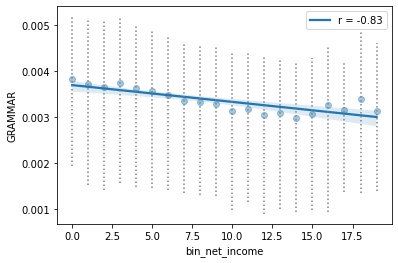

In [ ]:
r = bins_x_mistakes['GRAMMAR'].to_frame().corrwith(pd.Series(bins_x_mistakes.index, index=bins_x_mistakes.index)).values[0]
x = bins_x_mistakes.index
y = bins_x_mistakes['GRAMMAR']

q = 0.25
cat_freq = mistakes_x_ses.groupby(['user_id', 'cat_id'])['freq_per_word'].sum().loc[(slice(None), 'GRAMMAR')]
bin_cat_quantiles = a.join(cat_freq).fillna(0).groupby('bin_net_income')['freq_per_word'].quantile([q, 1-q]).unstack()
yerr = np.array([
    y.values - bin_cat_quantiles[q],
    bin_cat_quantiles[1 - q] - y.values
])
ax = sns.regplot(x=x, y=y, scatter_kws={'alpha': .4}, line_kws={'label': f'r = {r:.2f}'})
_, _, barlinecols = ax.errorbar(x, y, yerr=yerr, ls='', c='grey')
for b in barlinecols:
    b.set_linestyle(':')
ax.legend()

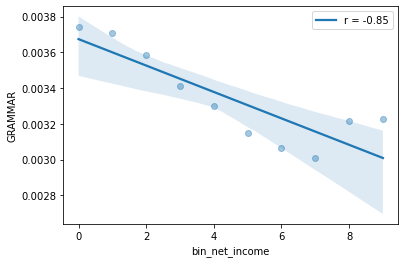

In [ ]:
r = bins_x_mistakes['GRAMMAR'].to_frame().corrwith(pd.Series(bins_x_mistakes.index, index=bins_x_mistakes.index)).values[0]
ax = sns.regplot(x=bins_x_mistakes.index, y=bins_x_mistakes['GRAMMAR'], scatter_kws={'alpha': .4}, line_kws={'label': f'r = {r:.2f}'})
ax.legend()

### User mistake cat freq

In [210]:
cat_id = 'GRAMMAR'
ses_id = 'net_income18'
udf = (
    lang.user_mistakes.loc[(slice(None), cat_id, slice(None)), :]
     .groupby('user_id')[['freq_per_word', 'count']]
     .sum()
     .join(lang.user_df.loc[lang.user_mask, 'cell_id'], how='right')
     .fillna(0)
)
# udf = udf.join(lang.select_ses_metric(ses_id).loc[reg_mask], on='cell_id', how='inner')
udf = udf.join(lang.select_ses_metric(ses_id), on='cell_id', how='inner')
udf.head()

,freq_per_word,count,cell_id,net_income18
user_id,,,,
0007831e4682dde226017fbf5d97c58c537a05fd1b55bf0ca4382c3866bdecc18591c37aba8f0b40ccf4899473deb37da34e85ac3cc41e2875fa6660d0fbb955,0.005348,9.0,E02001640,24200
8710f93402e565c7f432a2b71c75c4f8ea4978ba49284e35d1f2f75efcf21628c8216282a7b2980086f17df2463dab921f1fd948673d0749c6f33d241bed3f35,0.005000,3.0,E02001640,24200
bc2d2b0765f6803addf9e5abd51c746d1ff1816ed103fdf646c2f6fb9f82d6c23c5d968644cb76a81e8a5e6497656221cd7c47aa96e191e41c586a634cc1b86a,0.006676,5.0,E02001640,24200
d30fc7730309ab6cf7092a55dfd8b8c89609a653c630002f90d0af51fa0d275a71ae5cdd352a86e29443a8623fa18b31b1884603994063856c3f9645e806e411,0.001832,1.0,E02001640,24200
d78eb1ae189b470a8f613986eb930907fa65fd3e4c7a87b1500cc97a8ea291679b012e0c4916d6ace0f845e6f689468dadfd4c735a1a7bc8e99a4c7b8646f4e6,0.004287,4.0,E02001640,24200


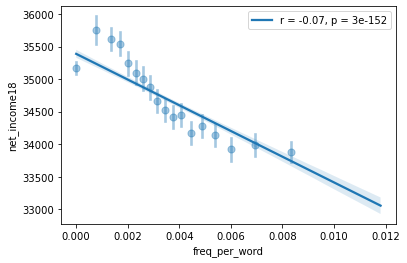

In [211]:
mistakes_ol = stats_utils.mask_outliers(udf['freq_per_word'], iqr_mult=2)
r, p = scipy.stats.pearsonr(udf.loc[mistakes_ol, 'freq_per_word'], udf.loc[mistakes_ol, ses_id])
ax = sns.regplot(
    data=udf.loc[mistakes_ol], x='freq_per_word', y=ses_id, x_bins=20,
    scatter=True, scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
)
ax.legend()

<AxesSubplot:xlabel='freq_per_word', ylabel='net_income18'>

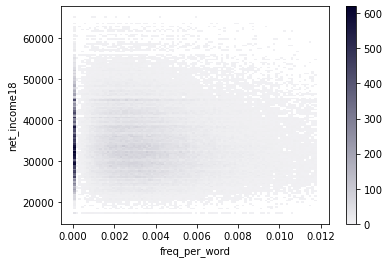

In [212]:
sns.histplot(
    x=udf.loc[mistakes_ol, 'freq_per_word'],
    y=udf.loc[mistakes_ol, ses_id],
    # binrange=((0, 5e-4), None),
    cmap="light:#03012d",
    cbar=True,
)

<AxesSubplot:xlabel='freq_per_word', ylabel='net_income18'>

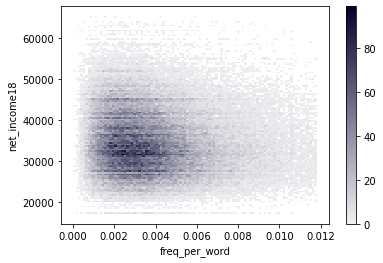

In [215]:
nonzero_mask = udf['freq_per_word'] > 0
sns.histplot(
    x=udf.loc[mistakes_ol & nonzero_mask, 'freq_per_word'],
    y=udf.loc[mistakes_ol & nonzero_mask, ses_id],
    # binrange=((0, 5e-4), None),
    cmap="light:#03012d",
    cbar=True,
)

Text(0.5, 1.0, 'London')

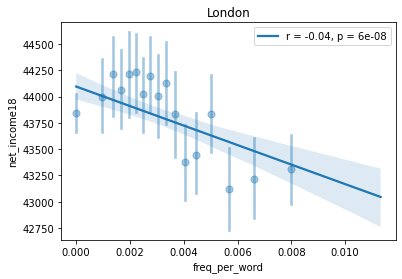

In [204]:
mistakes_ol = stats_utils.mask_outliers(udf['freq_per_word'], iqr_mult=2)
r, p = scipy.stats.pearsonr(udf.loc[mistakes_ol, 'freq_per_word'], udf.loc[mistakes_ol, ses_id])
ax = sns.regplot(
    data=udf.loc[mistakes_ol], x='freq_per_word', y=ses_id, x_bins=20,
    scatter=True, scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
)
ax.legend()
ax.set_title(city)

Text(0.5, 1.0, 'Manchester')

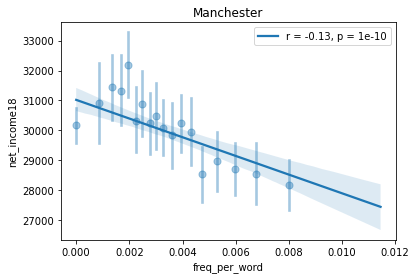

In [208]:
mistakes_ol = stats_utils.mask_outliers(udf['freq_per_word'], iqr_mult=2)
r, p = scipy.stats.pearsonr(udf.loc[mistakes_ol, 'freq_per_word'], udf.loc[mistakes_ol, ses_id])
ax = sns.regplot(
    data=udf.loc[mistakes_ol], x='freq_per_word', y=ses_id, x_bins=20,
    scatter=True, scatter_kws={'alpha': .4},
    line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
)
ax.legend()
ax.set_title(city)

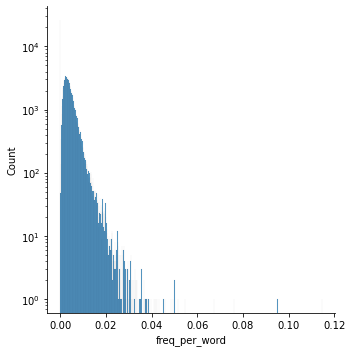

In [ ]:
sns.displot(udf['freq_per_word'], log_scale=[False, True])

In [120]:
from sklearn.cluster import KMeans

In [170]:
kmeans = KMeans(n_clusters=20).fit(udf['freq_per_word'].values[:, np.newaxis])

In [174]:
bins_df = pd.DataFrame({'label': kmeans.labels_, 'value': udf['freq_per_word'].values}).groupby('label')['value'].agg(['size', 'min', 'max', 'mean']).sort_values(by='min').reset_index()
bins_df.head()

,label,size,min,max,mean
0,4,26667,0.000000,0.000579,0.000013
1,12,11194,0.000580,0.001512,0.001139
2,1,15314,0.001512,0.002196,0.001869
3,16,15762,0.002197,0.002825,0.002512
4,7,15277,0.002826,0.003452,0.003136


In [175]:
udf['bin'] = kmeans.labels_
udf['bin'] = udf['bin'].map(bins_df['label'].to_dict())

In [176]:
bins_df = bins_df.join(udf.groupby('bin')[ses_id].mean())

In [177]:
bins_df.head()

,label,size,min,max,mean,net_income18
0,4,26667,0.000000,0.000579,0.000013,33867.358230
1,12,11194,0.000580,0.001512,0.001139,33671.804237
2,1,15314,0.001512,0.002196,0.001869,33721.408712
3,16,15762,0.002197,0.002825,0.002512,34128.915663
4,7,15277,0.002826,0.003452,0.003136,34233.730159


<AxesSubplot:xlabel='mean', ylabel='net_income18'>

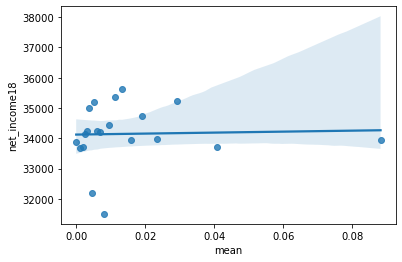

In [178]:
sns.regplot(x=bins_df['mean'], y=bins_df[ses_id])

In [ ]:
cells_mistake = lang.select_mistake(cat_id='GRAMMAR')
cells_mask = lang.user_df['cell_id'].isin(lang.relevant_cells)
user_ses = lang.user_df.loc[lang.user_mask & cells_mask, ['cell_id']].join(cells_ses, on='cell_id').drop(columns='cell_id')

## Mistakes vectors approach

In [158]:
cats_to_keep = ['STYLE', 'GRAMMAR', 'COMPOUNDING', 'CONFUSED_WORDS', 'COLLOCATIONS', 'PLAIN_ENGLISH', 'NONSTANDARD_PHRASES']

In [159]:
cells_mistakes_mat = lang.cells_mistakes.loc[lang.cells_mistakes.index.isin(cats_to_keep, level=1), 'uavg_freq_per_word'].droplevel('cat_id').unstack().fillna(0).loc[lang.relevant_cells]

In [77]:
cells_mistakes_mat.shape

(5022, 1685)

In [160]:
from sklearn.decomposition import PCA

TODO PCA with ses variables, what drives cinome variation

focus on city? London eg

In [161]:
n_components = 10
decomp = PCA(n_components=n_components).fit(cells_mistakes_mat.to_numpy())

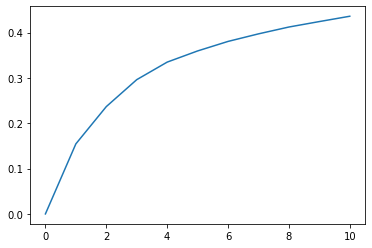

In [162]:
plt.plot(np.arange(n_components+1)[:20], np.insert(decomp.explained_variance_ratio_.cumsum(), 0, 0)[:20])

In [191]:
lang.lt_rules.loc['ENGLISH_WORD_REPEAT_BEGINNING_RULE']

cat_id              STYLE
default               NaN
distance_tokens       NaN
is_rule_group         NaN
min_prev_matches      NaN
name                  NaN
tags                  NaN
type                  NaN
Name: ENGLISH_WORD_REPEAT_BEGINNING_RULE, dtype: object

In [189]:
comps = decomp.components_
loading_order = np.argsort(np.abs(comps[1]))[::-1]
pd.Series(comps[1][loading_order], index=cells_mistakes_mat.columns[loading_order])

rule_id
ENGLISH_WORD_REPEAT_BEGINNING_RULE    9.895571e-01
GONNA                                 1.006274e-01
TO_TWO                                5.106833e-02
WANNA                                -4.061691e-02
THE_SUPERLATIVE                      -3.988878e-02
                                          ...     
BACK_IN_FORTH                         6.848147e-09
WALLED_WALLET                        -5.892304e-09
ESPECIALLY                           -3.719880e-09
IT_HAS_WORK_FOR                       2.113425e-09
IN_ON_WEEKDAY                        -1.840497e-09
Length: 1682, dtype: float64

In [295]:
import scipy.cluster.hierarchy as shc

In [166]:
proj_vectors = decomp.transform(cells_mistakes_mat.to_numpy())

In [186]:
comp_cell_val = pd.Series(proj_vectors[:, 1], index=cells_mistakes_mat.index, name='comp0')

In [104]:
comp_cell_val.head()

msoa11cd
E02000001   -0.000413
E02000003    0.000266
E02000004    0.000641
E02000008    0.000322
E02000009    0.000383
Name: comp0, dtype: float64

In [105]:
cells_density_df = lang.cells_geodf.loc[lang.cells_mask, ['shape__are']].join(lang.cells_ses_df.groupby('msoa11cd')['weight'].first()).join(comp_cell_val)
cells_density_df = cells_density_df.eval("density = weight / shape__are")
cells_density_df.corr()
# proj_vectirs

,shape__are,weight,comp0,density
shape__are,1.000000,-0.112980,-0.206737,-0.340520
weight,-0.112980,1.000000,0.077175,0.251733
comp0,-0.206737,0.077175,1.000000,0.099382
density,-0.340520,0.251733,0.099382,1.000000


In [149]:
m = lang.cells_geodf.join(cells_density_df['density'], how='inner').explore('density')

In [150]:
m.save(lang.paths.case_figs / 'density.html')

In [ ]:
lang.map_continuous_choro(comp_cell_val.rename('comp0_cell_val'), cmap='bwr', vcenter=0)

In [ ]:
lang.map_continuous_choro(comp_cell_val.rename('comp0_cell_val'), cmap='bwr', vcenter=0)

In [303]:
linkage = shc.linkage(vectors, method='ward')
# if max_n_clusters is None:
n_clusters = None
# else:
#     n_clusters = np.asarray(range(2, max_n_clusters + 1))
cut_tree = shc.cut_tree(linkage, n_clusters=np.asarray(range(2, 10 + 1)))

In [443]:
cl_df = pd.DataFrame({'level0': cut_tree[:, 0]}, index=cells_mistakes_mat.index)

In [437]:
m = lang.cells_geodf.join(cl_df, how='inner').explore('level0')

In [444]:
cl_df.join(lang.cells_ses_df['wavg'].unstack()['eduscore'], how='inner').groupby('level0').mean()

,eduscore
level0,
0,17.506897
1,22.945604


In [438]:
m.save(lang.paths.case_figs / 'basic_clustering.html')

## Regression approach

In [1044]:
X = lang.cells_ses_df['wavg'].unstack().loc[lang.relevant_cells]
y = lang.select_mistakes(cat_id=['GRAMMAR', 'STYLE', 'CONFUSED_WORDS']).loc[lang.relevant_cells]
has_all_ses = X.isna().sum(axis=1) == 0
X = X.loc[has_all_ses]
y = y.loc[has_all_ses]

In [1045]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler().fit(X)
X_rescaled = scaler.transform(X)

In [1046]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(oob_score=True, random_state=1)
reg = reg.fit(X_rescaled, y)

In [1047]:
reg.score(X_rescaled, y), reg.oob_score_

(0.9011202266693793, 0.27750973140641666)

In [1048]:
{
    feature: importance
    for feature, importance in sorted(
        zip(scaler.feature_names_in_, reg.feature_importances_),
        key=lambda t: np.abs(t[1])
    )
}

{'speak_cannot_to_well': 0.018958527792181337,
 'imdscore': 0.020961373837325378,
 'speak_cannot_to_very_well': 0.02143163538075025,
 'speak_cannot_to_not_well': 0.024904421831518045,
 'incscore': 0.02507151936314289,
 'eduscore': 0.026815836251035945,
 'empscore': 0.027137871819627006,
 'idcscore': 0.028856141624052714,
 'idoscore': 0.03109035856660598,
 'speak_cannot': 0.03132745265199847,
 'envscore': 0.0314319153734896,
 'net_income_after_housing': 0.03160615888697185,
 'net_income': 0.032443113439737076,
 'cypscore': 0.032765750338990436,
 'total_pop': 0.03366907484136607,
 'bhsscore': 0.03434474028444102,
 'wbscore': 0.03650262764756379,
 'gbscore': 0.03850938906172571,
 'criscore': 0.042606397382734834,
 'hddscore': 0.043507997737045584,
 'outscore': 0.05016140915793976,
 'indscore': 0.05033680278987521,
 'asscore': 0.28555948393988123}

In [1036]:
{
    feature: importance
    for feature, importance in sorted(
        zip(scaler.feature_names_in_, reg.feature_importances_),
        key=lambda t: np.abs(t[1])
    )
}

{'imdscore': 0.022463040119907858,
 'speak_cannot_to_well': 0.022468457411026044,
 'speak_cannot_to_very_well': 0.024241824880102524,
 'incscore': 0.02542147958839695,
 'speak_cannot_to_not_well': 0.02601287210509401,
 'empscore': 0.028639802388316652,
 'eduscore': 0.032302801106133566,
 'speak_cannot': 0.032368140748580035,
 'idcscore': 0.03269879334037918,
 'idoscore': 0.034172639906324694,
 'net_income_after_housing': 0.03447379597923409,
 'envscore': 0.035215492422139574,
 'net_income': 0.035717323701466325,
 'total_pop': 0.036252134427981246,
 'gbscore': 0.03725514880353054,
 'cypscore': 0.03742499204515113,
 'wbscore': 0.03869797413228561,
 'bhsscore': 0.04012934007003769,
 'criscore': 0.04087364818661567,
 'outscore': 0.04781623760172588,
 'indscore': 0.049066419861119294,
 'hddscore': 0.0492898119049699,
 'asscore': 0.23699782926948124}

In [1053]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=5).fit(X_rescaled, y, )

In [1054]:
ridge.best_score_

0.26771340655560805

In [1037]:
{
    feature: importance
    for feature, importance in sorted(
        zip(scaler.feature_names_in_, ridge.coef_),
        key=lambda t: np.abs(t[1])
    )
}

{'eduscore': 1.0571548899065107e-06,
 'outscore': -1.3693430602260397e-06,
 'speak_cannot_to_very_well': -2.2727338745002264e-06,
 'total_pop': 1.4905648268656386e-05,
 'speak_cannot': 2.0760922206552074e-05,
 'net_income_after_housing': -4.792557701252336e-05,
 'envscore': 5.4771653406601836e-05,
 'bhsscore': 5.6393768563688996e-05,
 'net_income': 5.965356234518014e-05,
 'criscore': 6.520528534235937e-05,
 'cypscore': -8.344428584037221e-05,
 'idcscore': -8.386656431901701e-05,
 'imdscore': -9.040128921239204e-05,
 'wbscore': -9.43090394738743e-05,
 'gbscore': -0.00010168360421774383,
 'speak_cannot_to_well': 0.00010935515044677719,
 'indscore': -0.00012106510970790016,
 'idoscore': -0.00014409493432999368,
 'speak_cannot_to_not_well': -0.00017880220780768527,
 'hddscore': 0.00018682881527022134,
 'empscore': -0.00022646926589051878,
 'incscore': 0.0003237969293317037,
 'asscore': 0.00039337274284452386}

In [1055]:
from sklearn.feature_selection import mutual_info_regression
{
    feature: importance
    for feature, importance in sorted(
        zip(scaler.feature_names_in_, mutual_info_regression(X_rescaled, y)),
        key=lambda t: np.abs(t[1])
    )
}

{'total_pop': 0.0,
 'speak_cannot_to_very_well': 0.006729514692355387,
 'indscore': 0.009117295487456545,
 'speak_cannot_to_not_well': 0.014899898674173073,
 'envscore': 0.01607764008867374,
 'speak_cannot_to_well': 0.017763183659489812,
 'bhsscore': 0.020888438491666328,
 'wbscore': 0.024502640598645264,
 'speak_cannot': 0.0326237240853402,
 'net_income': 0.03444051114048996,
 'outscore': 0.03590672468661893,
 'gbscore': 0.048205826102580396,
 'idoscore': 0.05459031015494187,
 'cypscore': 0.05764346246647989,
 'imdscore': 0.07210751591719333,
 'criscore': 0.07397986327792783,
 'empscore': 0.08241638592738099,
 'hddscore': 0.08838163958696565,
 'net_income_after_housing': 0.09200955714876446,
 'incscore': 0.09417683007862188,
 'idcscore': 0.10152738319616272,
 'eduscore': 0.13016842512378357,
 'asscore': 0.15937066667605748}

# Aggregate on region

In [1057]:
user_cell_acty

count  \
user_id                                            msoa11cd  is_daytime          
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584 True          1.0   
                                                   E02000586 True          1.0   
                                                   E02000590 False         1.0   
                                                   E02000977 False         1.0   
                                                             True          4.0   
...                                                                        ...   
ffffe3f11d2a318220bbbc9acae9e6542aab8d8fea5b27a... E02006932 True          2.0   
ffffe4bb74f99b011b2af47ddf6e823c01607de13973514... E02004914 False         2.0   
                                                             True         16.0   
                                                   E02004917 False        63.0   
                                                             True         12.0   

                                                                         prop_cell  \
user_id                                            msoa11cd  is_daytime              
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584 True         0.021739   
                                                   E02000586 True         0.021739   
                                                   E02000590 False        0.021739   
                                                   E02000977 False        0.021739   
                                                             True         0.086957   
...                                                                            ...   
ffffe3f11d2a318220bbbc9acae9e6542aab8d8fea5b27a... E02006932 True         0.035088   
ffffe4bb74f99b011b2af47ddf6e823c01607de13973514... E02004914 False        0.021505   
                                                             True         0.172043   
                                                   E02004917 False        0.677419   
                                                             True         0.129032   

                                                                         prop_cell_by_time  
user_id                                            msoa11cd  is_daytime                     
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584 True                 0.035714  
                                                   E02000586 True                 0.035714  
                                                   E02000590 False                0.055556  
                                                   E02000977 False                0.055556  
                                                             True                 0.142857  
...                                                                                    ...  
ffffe3f11d2a318220bbbc9acae9e6542aab8d8fea5b27a... E02006932 True                 0.080000  
ffffe4bb74f99b011b2af47ddf6e823c01607de13973514... E02004914 False                0.030769  
                                                             True                 0.571429  
                                                   E02004917 False                0.969231  
                                                             True                 0.428571  

[5393053 rows x 3 columns]

In [1063]:
lang.change_cell_sizes(GB='MSOA_BGC')
# lang.change_cell_sizes(GB='lad')

In [163]:
cells_cats_ufreq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum()

Keeping 334174 users out of 358334
Keeping 314 cells out of 336, 0 discarded from `cells_nr_users_th`


In [ ]:
for cat in cells_cats_ufreq.index.levels[1]:
    ax = r.cells_geodf.join(cells_cats_ufreq.loc[(slice(None), cat)]).plot('uavg_freq_per_word', legend=True)
    ax.set_title(cat)

In [ ]:
for cat in cells_cats_ufreq.index.levels[1]:
    ax = r.cells_geodf.join(cells_cats_ufreq.loc[(slice(None), cat)]).plot('uavg_freq_per_word', legend=True)
    ax.set_title(cat)

In [207]:
m = lang.map_interactive(
    cells_cats_ufreq.groupby('cell_id').sum(),
    tooltip_df=lang.cells_geodf.loc[
        :, lang.cells_geodf.columns.str.startswith(lang.regions[0].cell_size)
    ],
    save=True
)

In [ ]:
lads_pop = lang.cells_geodf[['lad20nm', 'shape__are']].join(lang.cells_ses_df.groupby('lad20cd')['weight'].first()).eval("density = weight / shape__are")
london_lads = lang.regions[0].cell_levels_corr.query("RGN20NM == 'London'")['LAD20CD'].unique()
lads_pop.loc[~lads_pop.index.isin(london_lads)].sort_values(by='density', ascending=False).head(20)

,lad20nm,shape__are,weight,density
lad20cd,,,,
E08000025,Birmingham,2.320300e+06,1112305.0,0.479380
E08000007,Stockport,1.078748e+06,288169.0,0.267133
E06000056,Central Bedfordshire,1.099404e+06,272421.0,0.247790
E08000015,Wirral,1.371528e+06,321700.0,0.234556
E08000035,Leeds,3.379603e+06,771857.0,0.228387
E08000003,Manchester,2.419054e+06,529282.0,0.218797
E08000012,Liverpool,2.263329e+06,479723.0,0.211955
E06000018,Nottingham,1.583141e+06,318582.0,0.201234
E08000028,Sandwell,2.072205e+06,319101.0,0.153991


In [ ]:
uavg_cat_freq = lang.cells_mistakes.groupby(['cell_id', 'cat_id'])['uavg_freq_per_word'].sum().unstack().fillna(0)

In [224]:
cells_cats_ufreq.unstack().corrwith(np.log10(lads_pop['density'].loc[lang.relevant_cells]))

cat_id
CASING                 0.441413
COLLOCATIONS           0.050731
COMPOUNDING           -0.009892
CONFUSED_WORDS         0.136335
GRAMMAR                0.218573
MISC                   0.076895
NONSTANDARD_PHRASES   -0.043059
PUNCTUATION            0.212295
REDUNDANCY            -0.092860
REPETITIONS_STYLE      0.107409
SEMANTICS              0.065852
STYLE                  0.386947
TYPOGRAPHY             0.330756
TYPOS                  0.367943
dtype: float64

<AxesSubplot:xlabel='density', ylabel='GRAMMAR'>

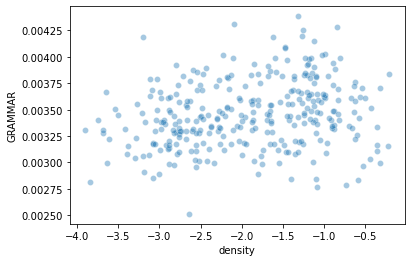

In [223]:
sns.scatterplot(
    x=np.log10(lads_pop['density'].loc[lang.relevant_cells]), 
    y=cells_cats_ufreq.unstack().loc[lang.relevant_cells, 'GRAMMAR'],
    alpha=0.4
)

# Assortativity?

link to mobility segregation?  dispersion in city of SES variables. papers on city ghettos. options fo rmob: twitter, covid mobility (pre-pandemic samples) assortativity index in cities. or from twitter interactions: eg are London users interatting more across cells with different ses than in Manchester 

## From Twitter visited cells

In [8]:
lang.user_cell_acty.head()

count  \
user_id                                            cell_id            
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584    1.0   
                                                   E02000586    1.0   
                                                   E02000590    1.0   
                                                   E02000977    5.0   
                                                   E02001062    2.0   

                                                              prop_cell  \
user_id                                            cell_id                
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584   0.021739   
                                                   E02000586   0.021739   
                                                   E02000590   0.021739   
                                                   E02000977   0.108696   
                                                   E02001062   0.043478   

                                                             res_cell_id  
user_id                                            cell_id                
000003962867f2d312d942838cdb2535b950589f2e85f31... E02000584   E02006902  
                                                   E02000586   E02006902  
                                                   E02000590   E02006902  
                                                   E02000977   E02006902  
                                                   E02001062   E02006902

38565.8 users on average in each of the 5 classes.
0.4809259464615954
38565.8 users on average in each of the 5 classes.
0.858588086819558


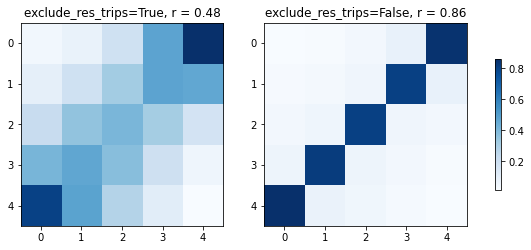

In [1086]:
cells_ses_metric = lang.select_ses_metric('net_income18')
nr_classes = 5
fig, axd = plt.subplot_mosaic([[True, False]], figsize=(10, 4))
normalize_incoming = False
for exclude_res_trips, ax in axd.items():
    assort = ses_data.user_acty_to_assort(
        lang.user_cell_acty,
        lang.user_residence_cell,
        cells_ses_metric,
        nr_classes,
        exclude_res_trips=exclude_res_trips,
        normalize_incoming=normalize_incoming,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    print(pearsonr)
    im = ax.imshow(
        assort.T[::-1], cmap='Blues', 
    )
    ax.set_title(f"exclude_res_trips={exclude_res_trips}, r = {pearsonr:.2f}")
fig.colorbar(im, ax=list(axd.values()), shrink=0.6)

In [10]:
cat_id = ['GRAMMAR'] #'GRAMMAR'
ses_id = 'net_income18'
ses_x_grammar_dict = {}
for city, city_d in lang.iter_subregs(subreg_df, ses_metric=ses_id, cat_id=cat_id):
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    mistake_values = city_d['cells_mistake']
    ses_values = city_d['cells_ses_metric']
    mistake_ol_mask = stats_utils.mask_outliers(mistake_values, iqr_mult=3).reindex(mistake_values.index).fillna(False)
    ses_ol_mask = stats_utils.mask_outliers(ses_values, iqr_mult=3).reindex(ses_values.index).fillna(False)
    ol_mask = ses_ol_mask & mistake_ol_mask

    r, p = scipy.stats.pearsonr(ses_values.loc[ol_mask], mistake_values.loc[ol_mask])
    ses_x_grammar_dict[city] = {}
    ses_x_grammar_dict[city]['pearsonr'] = r
    ses_x_grammar_dict[city]['p_value'] = p

285 cells in Birmingham.
Keeping 156055 users out of 358334
Keeping 4879 cells out of 7201, 2322 discarded from `cells_nr_users_th`
55 cells in Bristol, City of.
168 cells in Leeds.
139 cells in Liverpool.
983 cells in London.
306 cells in Manchester.
145 cells in Newcastle upon Tyne.
103 cells in Sheffield.


In [105]:
nr_classes = 5
exclude_res_trips = True
# if normalize_incoming, sum over rows in heatmap = 1
normalize_incoming = False
assort_dict = {}

for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18'):
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    assort = ses_data.user_acty_to_assort(
        nr_classes=nr_classes,
        exclude_res_trips=exclude_res_trips,
        normalize_incoming=normalize_incoming,
        **city_d,
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

285 cells in Birmingham.
642.6 users on average in each of the 5 classes.
55 cells in Bristol, City of.
363.0 users on average in each of the 5 classes.
168 cells in Leeds.
850.6 users on average in each of the 5 classes.
139 cells in Liverpool.
949.4 users on average in each of the 5 classes.
983 cells in London.
5524.6 users on average in each of the 5 classes.
306 cells in Manchester.
1970.6 users on average in each of the 5 classes.
145 cells in Newcastle upon Tyne.
815.0 users on average in each of the 5 classes.
103 cells in Sheffield.
491.0 users on average in each of the 5 classes.


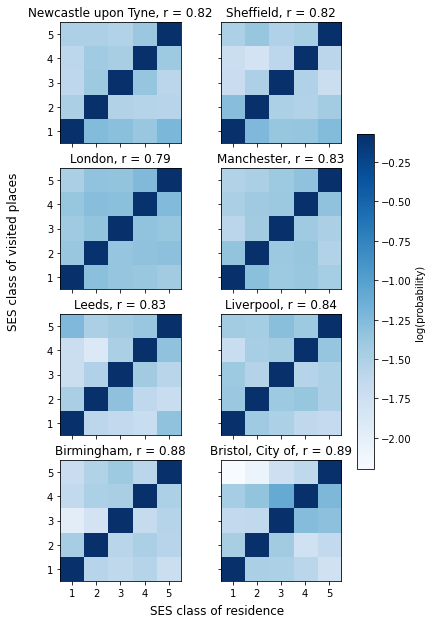

In [43]:
# exclude_res_trips = False
fig, axd = ses_viz.assort_mosaic(
    assort_dict, nr_cols=2, figsize=(15/2.54, 26/2.54), log_scale=True
)

Text(0, 0.5, "Assortativity matrix' pearson r")

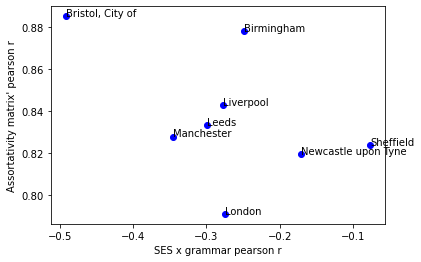

In [97]:
fig, ax = plt.subplots()
for city in ses_x_grammar_dict.keys():
    x = ses_x_grammar_dict[city]['pearsonr']
    y = assort_dict[city]['pearsonr']
    ax.scatter(x, y, c='b')
    ax.annotate(city, (x, y))
ax.set_xlabel('SES x grammar pearson r')
ax.set_ylabel("Assortativity matrix' pearson r")

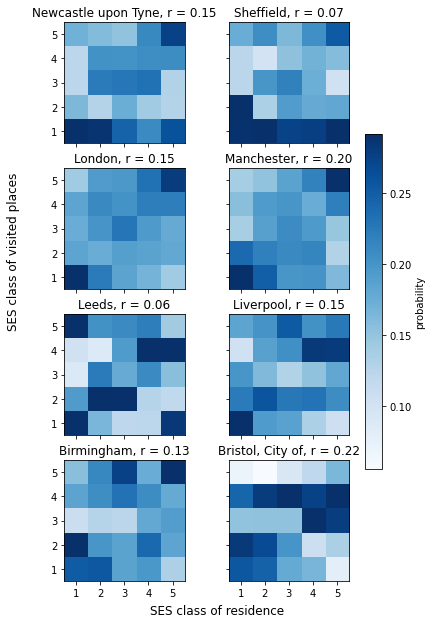

In [45]:
# exclude_res_trips = True
fig, axd = ses_viz.assort_mosaic(assort_dict, nr_cols=2, figsize=(15/2.54, 26/2.54))

Text(0, 0.5, "Assortativity matrix' pearson r")

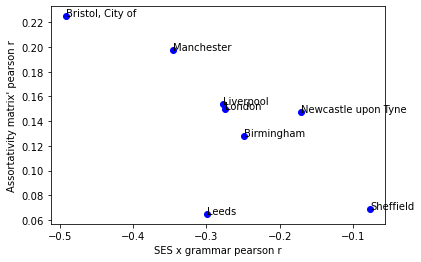

In [106]:
fig, ax = plt.subplots()
for city in ses_x_grammar_dict.keys():
    x = ses_x_grammar_dict[city]['pearsonr']
    y = assort_dict[city]['pearsonr']
    ax.scatter(x, y, c='b')
    ax.annotate(city, (x, y))
ax.set_xlabel('SES x grammar pearson r')
ax.set_ylabel("Assortativity matrix' pearson r")

segment on y axis of lorenz curve?

rndom sampling of users like bootstrap to see if trend still there, erro rbars

modelling? like voter model people copy "mistakes"

Text(0, 0.5, "Assortativity matrix' pearson r")

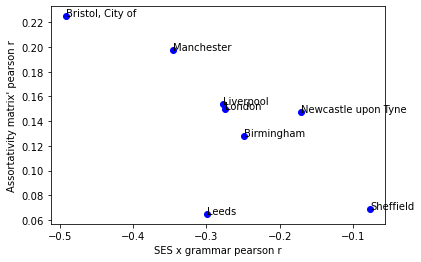

In [1009]:
fig, ax = plt.subplots()
for city in ses_x_grammar_dict.keys():
    x = ses_x_grammar_dict[city]['pearsonr']
    y = assort_dict[city]['pearsonr']
    ax.scatter(x, y, c='b')
    ax.annotate(city, (x, y))
ax.set_xlabel('SES x grammar pearson r')
ax.set_ylabel("Assortativity matrix' pearson r")

what's going on in eg Bristol? everyone going to those places with SES class == 4 -> plot map 

In [896]:
# key = 'Bristol, City of'
key = 'Leeds'
cells_mask = lang.make_subregions_mask(subreg_df.loc[('GB', [key]), :], set_cells_mask=False)
subreg_res_cell = ses_data.get_cells_subset_user_res(
    lang.user_residence_cell, cells_mask
)
subreg_user_cell_acty = ses_data.get_cells_subset_user_acty(
    user_cell_acty, subreg_res_cell, cells_mask, exclude_res_trips=exclude_res_trips
)
od_df = (
    subreg_user_cell_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
)
od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

subreg_cells_ses_metric = cells_ses_metric.loc[cells_mask.loc[cells_mask].index]
user_class = ses_data.attr_user_to_class(
    subreg_res_cell, subreg_cells_ses_metric, nr_classes
)
cells_class = subreg_res_cell.join(user_class).groupby('cell_id')['net_income18'].first()

107 cells in Leeds.
658.8 users on average in each of the 5 classes.


In [897]:
a = subreg_user_cell_acty.join(cells_class)
a.loc[a['net_income18'] == 5].groupby('cell_id')['prop_cell'].sum()

cell_id
E02002350     24.894485
E02006875    505.888618
Name: prop_user, dtype: float64

In [ ]:
z_plot = pd.Series(0, index=cells_mask.loc[cells_mask].index, name='a')
z_plot.loc['E02003043'] = 1
lang.map_interactive(z_plot)

In [401]:
rng = np.random.default_rng()
rnd_assort = np.zeros_like(assort)
nr_iter = 100
for _ in tqdm(range(nr_iter)):
    rnd_user_acty = ses_data.rewire_user_cell_acty(
        subreg_user_cell_acty, lang.user_residence_cell, rng,
        exclude_res_trips=exclude_res_trips
    )
    rnd_od_df = (
        rnd_user_acty.groupby(['res_cell_id', 'cell_id'])[['prop_cell']].sum()
    )
    rnd_od_df = rnd_od_df / rnd_od_df.groupby(od_groupby_col).transform('sum')
    rnd_interclass_od = ses_data.inter_cell_to_inter_class_od(
        rnd_od_df,
        cells_class.loc[cells_mask],
        weight_col='prop_cell'
    )
    rnd_assort = rnd_assort + ses_data.interclass_od_to_assort(
        rnd_interclass_od, normalize_incoming=normalize_incoming
    )
rnd_assort = rnd_assort / nr_iter

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.73it/s]


In [402]:
assort / rnd_assort

to_net_income18,1,2,3,4,5
from_net_income18,,,,,
1,0.912334,0.806823,0.681424,4.767255,0.698196
2,0.827754,0.818944,0.666239,5.599743,0.555857
3,0.587446,0.572704,0.756593,7.873770,0.910638
4,0.552364,0.305348,1.484816,10.807581,1.203063
5,0.259800,0.379411,1.277969,6.835770,2.147101


In [466]:
assort.values.sum(axis=1-int(normalize_incoming))

array([1., 1., 1., 1., 1.])

## Entropies

285 cells in Birmingham.
642.6 users on average in each of the 5 classes.
69.0% of users and 88.6% of trips removed from exclusion of residence trips
55 cells in Bristol, City of.
363.0 users on average in each of the 5 classes.
66.2% of users and 86.8% of trips removed from exclusion of residence trips
168 cells in Leeds.
850.6 users on average in each of the 5 classes.
59.6% of users and 84.9% of trips removed from exclusion of residence trips
139 cells in Liverpool.
949.4 users on average in each of the 5 classes.
55.3% of users and 80.5% of trips removed from exclusion of residence trips
983 cells in London.
5524.6 users on average in each of the 5 classes.
54.3% of users and 81.5% of trips removed from exclusion of residence trips
306 cells in Manchester.
1970.6 users on average in each of the 5 classes.
55.5% of users and 81.8% of trips removed from exclusion of residence trips
145 cells in Newcastle upon Tyne.
815.0 users on average in each of the 5 classes.
51.1% of users and 8

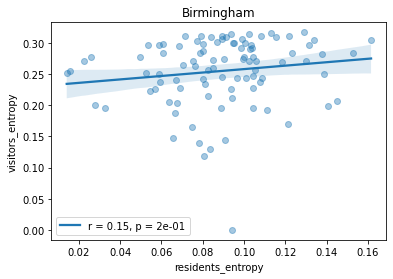

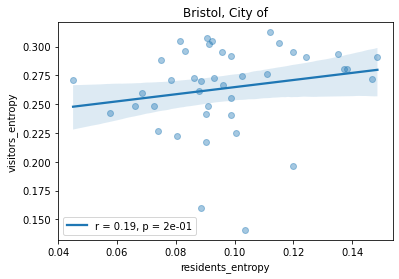

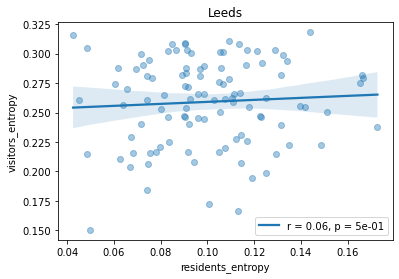

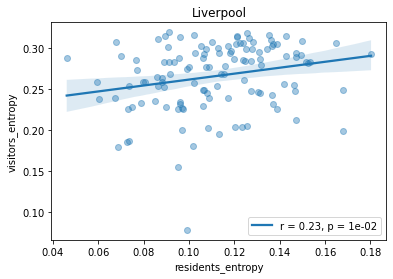

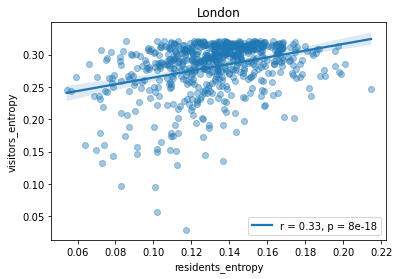

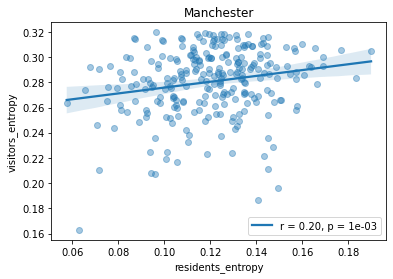

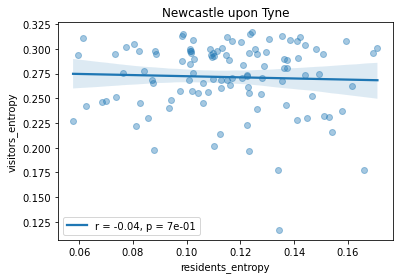

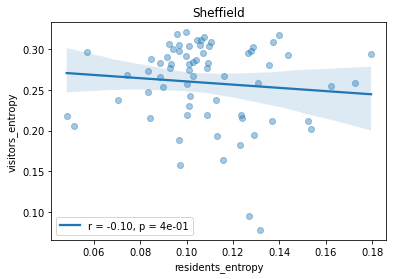

In [133]:
exclude_res_trips = True
nr_classes = 5
for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18'):
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    cell_entropies_df = ses_data.get_cell_entropies_df(
        nr_classes=nr_classes, exclude_res_trips=exclude_res_trips, **city_d
    )
    # cell_nr_visits = cells_subset_user_acty['count'].groupby('cell_id').sum()
    mask = slice(None) # cell_nr_visits > 1000
    x = cell_entropies_df.loc[mask, 'residents_entropy']
    y = cell_entropies_df.loc[mask, 'visitors_entropy']
    r, p = scipy.stats.pearsonr(x, y)
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=x,
        y=y,
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)

285 cells in Birmingham.
642.6 users on average in each of the 5 classes.
55 cells in Bristol, City of.
363.0 users on average in each of the 5 classes.
168 cells in Leeds.
850.6 users on average in each of the 5 classes.
139 cells in Liverpool.
949.4 users on average in each of the 5 classes.
983 cells in London.
5524.6 users on average in each of the 5 classes.
306 cells in Manchester.
1970.6 users on average in each of the 5 classes.
145 cells in Newcastle upon Tyne.
815.0 users on average in each of the 5 classes.
103 cells in Sheffield.
491.0 users on average in each of the 5 classes.


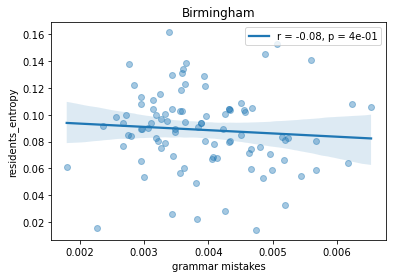

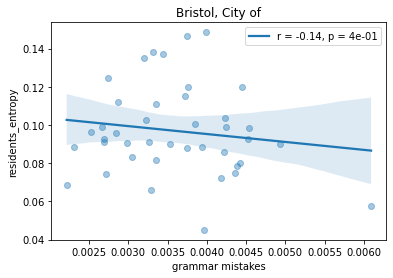

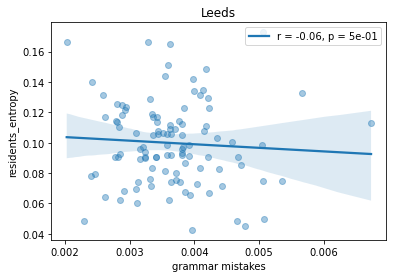

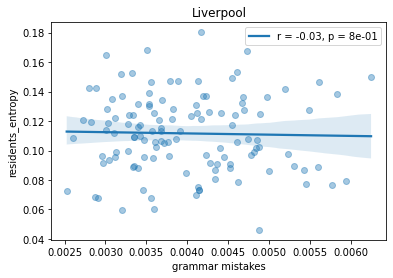

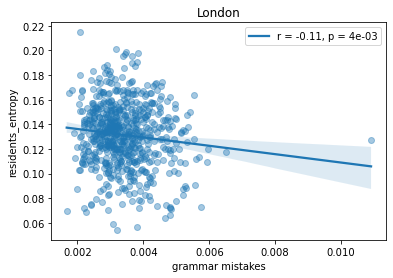

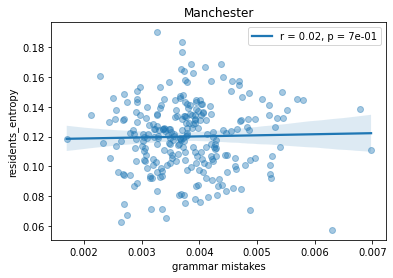

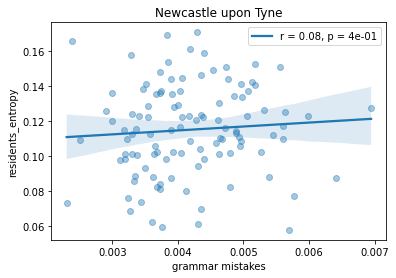

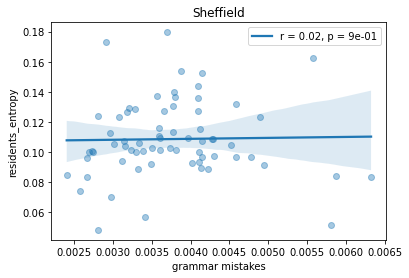

In [128]:
exclude_res_trips = True
nr_classes = 5
for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18', cat_id='GRAMMAR'):
    city_d['cells_mask'] = None # already done in lang.iter_subregs
    cells_mistake = city_d.pop('cells_mistake')
    cell_entropies_df = ses_data.get_cell_entropies_df(
        nr_classes=nr_classes, exclude_res_trips=exclude_res_trips, **city_d
    )
    # cell_nr_visits = cells_subset_user_acty['count'].groupby('cell_id').sum()
    mask = slice(None) # cell_nr_visits > 1000
    x = cells_mistake
    # x = city_d['cells_ses_metric'].loc[mask]
    y = cell_entropies_df.loc[mask, 'residents_entropy']
    # y = cell_entropies_df.loc[mask, 'visitors_entropy']
    r, p = scipy.stats.pearsonr(x, y)
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=x,
        y=y,
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)

983 cells in London.
5524.6 users on average in each of the 5 classes.
57 cells in Manchester.
733.8 users on average in each of the 5 classes.
132 cells in Birmingham.
472.4 users on average in each of the 5 classes.
61 cells in Liverpool.
617.4 users on average in each of the 5 classes.
107 cells in Leeds.
658.8 users on average in each of the 5 classes.
70 cells in Sheffield.
415.4 users on average in each of the 5 classes.
55 cells in Bristol, City of.
363.0 users on average in each of the 5 classes.


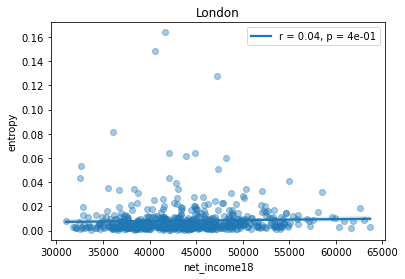

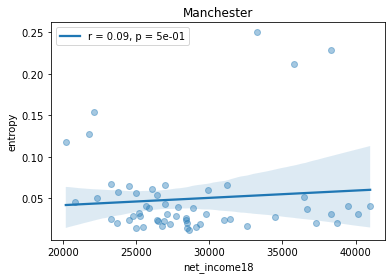

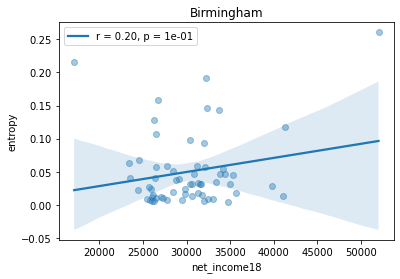

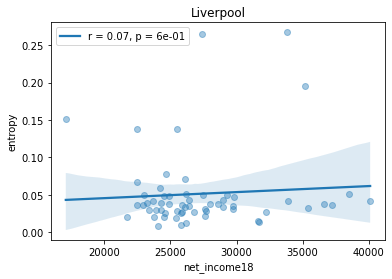

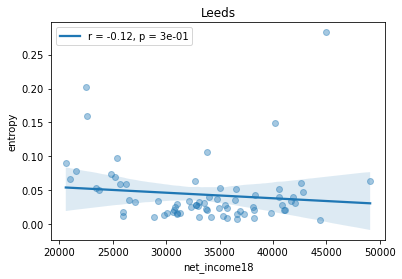

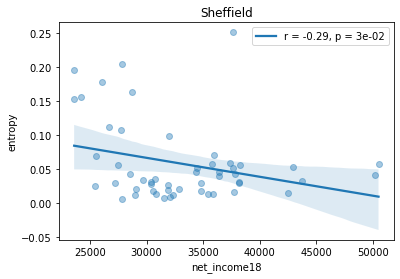

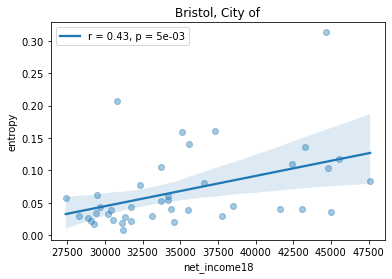

In [756]:
exclude_res_trips = True
nr_classes = 5
for city, city_d in lang.iter_subregs(subreg_df, ses_metric='net_income18'):
    # reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    # cells_subset_user_res = ses_data.get_cells_subset_user_res(
    #     lang.user_residence_cell, cells_mask=reg_mask
    # )
    cells_subset_user_res = city_d['user_res_cell']
    # cells_subset_ses_metric = ses_data.get_cells_subset_ses_metric(cells_ses_metric, reg_mask)
    cells_subset_ses_metric = city_d['cells_ses_metric']
    user_class = ses_data.attr_user_to_class(
        cells_subset_user_res, cells_subset_ses_metric, nr_classes
    )
    cells_class = (
        cells_subset_user_res.join(user_class)
         .groupby('cell_id')[user_class.name]
         .first()
    )
    # cells_subset_user_acty = ses_data.get_cells_subset_user_acty(
    #     user_cell_acty, cells_subset_user_res,
    #     cells_mask=reg_mask, exclude_res_trips=exclude_res_trips
    # )
    cells_subset_user_acty = city_d['user_cell_acty']
    cells_subset_user_acty = cells_subset_user_acty.join(cells_class.rename('cell_class')).join(user_class.rename('user_class'))

    acty_col = 'count' # count barely any difference with prop_cell
    user_class_acty = cells_subset_user_acty.groupby(['user_class', 'cell_id'])[acty_col].sum().to_frame()
    user_class_acty['prop'] = user_class_acty[acty_col] / user_class_acty[acty_col].groupby('user_class').transform('sum')
    cell_visitors_entropy = -1 / nr_classes * (user_class_acty['prop'] * np.log(user_class_acty['prop'])).groupby('cell_id').sum().rename('entropy')
    # cell_nr_visits = cells_subset_user_acty['count'].groupby('cell_id').sum()
    mask = slice(None) # cell_nr_visits > 1000
    x = cells_subset_ses_metric.loc[mask]
    y = cell_visitors_entropy.loc[mask]
    r, p = scipy.stats.pearsonr(x, y)
    fig, ax = plt.subplots()
    ax = sns.regplot(
        x=x,
        y=y,
        scatter_kws={'alpha': .4},
        line_kws={'label': f'r = {r:.2f}, p = {p:.0e}'},
        ax=ax,
    )
    ax.legend()
    ax.set_title(city)

In [848]:
exclude_res_trips = True
nr_classes = 5
city = 'London'
reg_mask = lang.make_subregions_mask(subreg_df.loc[(slice(None), 'London'), :])
cells_subset_user_res = ses_data.get_cells_subset_user_res(
    lang.user_residence_cell, cells_mask=reg_mask
)
cells_subset_ses_metric = ses_data.get_cells_subset_ses_metric(cells_ses_metric, reg_mask)
user_class = ses_data.attr_user_to_class(
    cells_subset_user_res, cells_subset_ses_metric, nr_classes
)
cells_class = (
    cells_subset_user_res.join(user_class)
        .groupby('cell_id')[user_class.name]
        .first()
)
cells_subset_user_acty = ses_data.get_cells_subset_user_acty(
    user_cell_acty, cells_subset_user_res,
    cells_mask=reg_mask, exclude_res_trips=exclude_res_trips
)
cells_subset_user_acty = cells_subset_user_acty.join(cells_class.rename('cell_class')).join(user_class.rename('user_class'))

983 cells in London.
5524.6 users on average in each of the 5 classes.


In [854]:
nr_outres_visits = cells_subset_user_acty['count'].groupby('user_id').sum()
nr_outres_visits.size, (nr_outres_visits > 10).sum()

(22194, 6104)

In [855]:
user_visited_cells_entropy = -1 / nr_classes * (cells_subset_user_acty['prop_cell'] * np.log(cells_subset_user_acty['prop_cell'])).groupby('user_id').sum().rename('visited_entropy')

In [857]:
acty_col = 'count' # count barely any difference with prop_cell
user_class_acty = cells_subset_user_acty.groupby(['user_class', 'cell_id'])[acty_col].sum().to_frame()
user_class_acty['prop'] = user_class_acty[acty_col] / user_class_acty[acty_col].groupby('user_class').transform('sum')
cell_visitors_entropy = -1 / nr_classes * (user_class_acty['prop'] * np.log(user_class_acty['prop'])).groupby('cell_id').sum().rename('visitors_entropy')

TODO: remove outlier, also plot corr vs maximum entropy cutoff

why exclude_res_trips switch reduces abs corr

## Regression with those + income?

In [858]:
cell_residents_entropy = lang.user_residence_cell.join(user_visited_cells_entropy, how='inner').groupby('cell_id')['visited_entropy'].mean().rename('residents_entropy')

In [883]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

In [875]:
X = cells_subset_ses_metric.to_frame()
y = lang.select_mistakes(cat_id=['GRAMMAR']).loc[reg_mask]
print(X.isnull().sum(), X.shape, y.shape)

scaler = StandardScaler().fit(X.values)
X_rescaled = scaler.transform(X.values)

reg = RandomForestRegressor(oob_score=True, random_state=1)
reg = reg.fit(X_rescaled, y)
reg.score(X_rescaled, y), reg.oob_score_

net_income18    0
dtype: int64 (652, 1) (652,)


(0.3857084774145446, -0.14967452665742487)

In [876]:
X = pd.concat(
    [
        cells_subset_ses_metric,
        cell_visitors_entropy,
        cell_residents_entropy,
    ],
    axis=1,
)
y = lang.select_mistakes(cat_id=['GRAMMAR']).loc[reg_mask]
print(X.isnull().sum(), X.shape, y.shape)

scaler = StandardScaler().fit(X.values)
X_rescaled = scaler.transform(X.values)

reg = RandomForestRegressor(oob_score=True, random_state=1)
reg = reg.fit(X_rescaled, y)
print(reg.score(X_rescaled, y), reg.oob_score_)

net_income18         0
visitors_entropy     0
residents_entropy    0
dtype: int64 (652, 3) (652,)


(0.8659200629778985, 0.017294581028106326)

In [880]:
def keep_subset_subreg(subreg_df, subset):
    return subreg_df.loc[(slice(None), subset, slice(None)), :]

In [1026]:
cells_subset_user_acty.head()

count  \
user_id                                            cell_id            
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900    3.0   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905    2.0   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957    2.0   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905    1.0   
                                                   E02006898    1.0   

                                                              prop_user  \
user_id                                            cell_id                
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900        1.0   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905        1.0   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957        1.0   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905        0.5   
                                                   E02006898        0.5   

                                                             res_cell_id  \
user_id                                            cell_id                 
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900   E02002012   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905   E02006897   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957   E02001952   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905   E02006899   
                                                   E02006898   E02006899   

                                                              isin_area  \
user_id                                            cell_id                
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900       True   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905       True   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957       True   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905       True   
                                                   E02006898       True   

                                                              cell_class  \
user_id                                            cell_id                 
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900           2   
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905           4   
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957           3   
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905           4   
                                                   E02006898           4   

                                                              user_class  
user_id                                            cell_id                
0016e048c7530b67b8518eac9f5bfeec7f126c1d72dab63... E02006900           1  
0027e996339de1bd2beb817c7145884955703dae4582628... E02001905           2  
002c2953b4fae05d43c805151b1bd6758a05ec7e20c5b83... E02001957           1  
003b5a20a77be78f13920606d1398bc64c7571b6d60309b... E02001905           5  
                                                   E02006898           5

In [1024]:
exclude_res_trips = True
nr_classes = 5
subset_subreg = keep_subset_subreg(subreg_df, ['London'])

for city, reg_mask in lang.iter_subregs(subreg_df):
    cells_subset_user_res = ses_data.get_cells_subset_user_res(
        lang.user_residence_cell, cells_mask=reg_mask
    )
    cells_subset_ses_metric = ses_data.get_cells_subset_ses_metric(
        cells_ses_metric, reg_mask
    )
    user_class = ses_data.attr_user_to_class(
        cells_subset_user_res, cells_subset_ses_metric, nr_classes
    )
    cells_class = (
        cells_subset_user_res.join(user_class)
         .groupby('cell_id')[user_class.name]
         .first()
         .rename('cell_class')
    )
    cells_subset_user_acty = ses_data.get_cells_subset_user_acty(
        user_cell_acty, cells_subset_user_res,
        cells_mask=reg_mask, exclude_res_trips=exclude_res_trips
    )
    cells_subset_user_acty = cells_subset_user_acty.join(cells_class).join(user_class)

    user_visited_cells_entropy = -1 / nr_classes * (cells_subset_user_acty['prop_cell'] * np.log(cells_subset_user_acty['prop_cell'])).groupby('user_id').sum().rename('visited_entropy')

    acty_col = 'count' # count barely any difference with prop_cell
    user_class_acty = cells_subset_user_acty.groupby(['user_class', 'cell_id'])[acty_col].sum().to_frame()
    user_class_acty['prop'] = user_class_acty[acty_col] / user_class_acty[acty_col].groupby('user_class').transform('sum')
    cell_visitors_entropy = -1 / nr_classes * (user_class_acty['prop'] * np.log(user_class_acty['prop'])).groupby('cell_id').sum().rename('visitors_entropy')

    cell_residents_entropy = lang.user_residence_cell.join(user_visited_cells_entropy, how='inner').groupby('cell_id')['visited_entropy'].mean().rename('residents_entropy')

    X = pd.concat(
        [
            cells_subset_ses_metric,
            cell_visitors_entropy,
            cell_residents_entropy,
        ],
        axis=1,
    )
    y = lang.select_mistakes(cat_id=['GRAMMAR']).loc[reg_mask]
    scaler = StandardScaler().fit(X)
    X_rescaled = scaler.transform(X)

    reg = RandomForestRegressor(oob_score=True, random_state=1)
    reg = reg.fit(X_rescaled, y)
    print(
        f"RandomForestRegressor score: {reg.score(X_rescaled, y)} ", 
        f"Out-of-bag score: {reg.oob_score_} ",
        reg.feature_importances_
    )

    ridge = RidgeCV(cv=None).fit(X_rescaled, y, )
    print(
        f"Ridge CV best score: {ridge.best_score_} ",
        # f"coefs: {ridge.coef_} ",
        {
            feature: importance
            for feature, importance in sorted(
                zip(scaler.feature_names_in_, ridge.coef_),
                key=lambda t: np.abs(t[1])
            )
        },
    )

285 cells in Birmingham.
642.6 users on average in each of the 5 classes.


array([0.31866886, 0.40349608, 0.27783507])

## From census commuting OD

In [25]:
lang.cells_ses_df.loc[(slice(None), ['net_income18', 'net_income_after_housing18']), 'wavg'].unstack().describe()

metric,net_income18,net_income_after_housing18
count,7201.000000,7201.000000
mean,34489.029301,28104.749340
std,7060.623530,5661.093308
min,17100.000000,12500.000000
25%,29200.000000,24200.000000
50%,33600.000000,28000.000000
75%,38900.000000,31700.000000
max,65300.000000,52200.000000


In [ ]:
lang.change_cell_sizes(GB='MSOA_BGC')

In [24]:
lang.add_ses_idx(['net_income18', 'net_income_after_housing18']) #, 'net_income_after_housing'])

In [559]:
commuting_od = pd.read_csv(lang.paths.ext_data / 'wu01ew_v2.csv.gz').rename(columns={'Area of residence': 'res_cell_id', 'Area of workplace': 'cell_id'}).set_index(['res_cell_id', 'cell_id'])['All categories: Sex'].rename('count').to_frame()

In [565]:
cells_ses_metric = lang.select_ses_metric('net_income18')
nr_classes = 5
exclude_res_trips = False
# if normalize_incoming, sum over rows in heatmap = 1
normalize_incoming = False
od_groupby_col = 'cell_id' if normalize_incoming else 'res_cell_id'
assort_dict = {}
for city, city_df in subreg_df.groupby('subreg'):
    reg_mask = lang.make_subregions_mask(city_df, set_cells_mask=False)
    reg_cells = cells_mask.loc[cells_mask]
    od_df = (
        commuting_od.join(reg_cells.rename_axis('res_cell_id'), how='inner')[['count']]
         .join(reg_cells.rename_axis('cell_id'), how='inner')[['count']]
    )
    nr_residents_per_cell = od_df.groupby('res_cell_id')['count'].sum()
    if exclude_res_trips:
        od_df = od_df.loc[od_df.index.get_level_values(0) != od_df.index.get_level_values(1)]
    od_df = od_df / od_df.groupby(od_groupby_col).transform('sum')

    subreg_cells_ses_metric = cells_ses_metric.loc[reg_cells.index]
    cells_class = ses_data.attr_cell_to_class(
        subreg_cells_ses_metric, nr_classes, nr_residents_per_cell
    )
    interclass_od = ses_data.inter_cell_to_inter_class_od(
        od_df,
        cells_class.loc[cells_mask],
        # weight_col='prop_cell'
    )
    assort = ses_data.interclass_od_to_assort(
        interclass_od, normalize_incoming=normalize_incoming
    )
    pearsonr = stats_utils.matrix_pearsonr(assort.values)
    assort_dict[city] = {'assort': assort, 'pearsonr': pearsonr}

983 cells in London.
130.4 cells on average in each of the 5 classes.
57 cells in Manchester.
11.4 cells on average in each of the 5 classes.
132 cells in Birmingham.
12.2 cells on average in each of the 5 classes.
61 cells in Liverpool.
12.0 cells on average in each of the 5 classes.
107 cells in Leeds.
14.6 cells on average in each of the 5 classes.
70 cells in Sheffield.
10.4 cells on average in each of the 5 classes.
55 cells in Bristol, City of.
8.2 cells on average in each of the 5 classes.


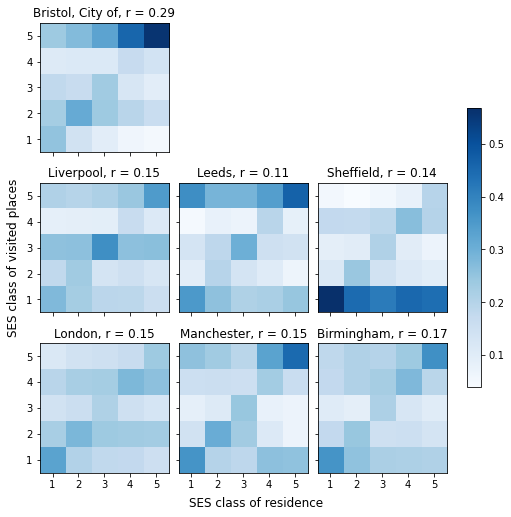

In [566]:
nr_cols = 3
mosaic = list(assort_dict.keys())
nr_empty = nr_cols - len(mosaic) % nr_cols
nr_rows = len(mosaic) // nr_cols + int(nr_empty > 0)
mosaic.extend(['.'] * nr_empty)
mosaic = np.vstack([
    np.array(mosaic).reshape(nr_rows, nr_cols),
    # np.array(['cax'] * nr_cols)
])[::-1, :]
fig, axd = plt.subplot_mosaic(
    mosaic, sharex=True, sharey=True, figsize=(17.8/2.54, 18/2.54),
    constrained_layout=True,
)
assort_mins, assort_maxs = zip(*[
    (city_dict['assort'].values.min(), city_dict['assort'].values.max()) 
    for city_dict in assort_dict.values()
])
for i, (city, city_dict) in enumerate(assort_dict.items()):
    ax = axd[city]
    cbar = i == 0
    pearsonr = city_dict['pearsonr']
    assort = city_dict['assort']
    im = ax.imshow(
        assort.T[::-1], cmap='Blues', vmin=min(assort_mins), vmax=max(assort_maxs),
    )
    ax.set_title(f"{city}, r = {pearsonr:.2f}")

ax.set_xticks(np.arange(assort.shape[0]), assort.T[::-1].columns.astype(str))
ax.set_yticks(np.arange(assort.shape[0]), assort.T[::-1].index.astype(str))
fig.supxlabel('SES class of residence')
fig.supylabel('SES class of visited places')
fig.colorbar(im, ax=list(axd.values()), shrink=0.6)

for Germany there's a paper by Dirk about dialect usage. maybe use when/if focus on Germany later on 



TODO measure if heap's law for user when concatenating their tweets?